# California Housing Wide & Deep MLP

## Imports

In [72]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import joblib
from sklearn.metrics import r2_score
from mltoolkit.neural_networks import nn_learning_curve
from mltoolkit.utils import dump_keras_model,dump_csv

## Loading the Datasets

In [6]:
X_train = np.loadtxt("Datasets\\Raw Data\\X_train.csv",delimiter=',',skiprows=1)
X_valid = np.loadtxt("Datasets\\Raw Data\\X_valid.csv",delimiter=',',skiprows=1)
X_test = np.loadtxt("Datasets\\Raw Data\\X_test.csv",delimiter=',',skiprows=1)
y_train = np.loadtxt("Datasets\\Raw Data\\y_train.csv",delimiter=',',skiprows=1)
y_valid = np.loadtxt("Datasets\\Raw Data\\y_valid.csv",delimiter=',',skiprows=1)
y_test = np.loadtxt("Datasets\\Raw Data\\y_test.csv",delimiter=',',skiprows=1)

In [8]:
X_train.shape,X_valid.shape,X_test.shape,y_train.shape,y_valid.shape,y_test.shape

((11610, 8), (3870, 8), (5160, 8), (11610,), (3870,), (5160,))

## Preparing the Datasets

In [51]:
def split_input(X):
    return X[:,:5],X[:,2:]

Here we split the input dataset X into two parts, one part for Wide and one part for Deep.\
The Deep partition will be passed into the hidden layers to learn deep patterns.\
Wide partition will be directly passed to the output layer.\
Slice A: 0 to 2\
Slice B: 1 to 7

In [52]:
X_train_a,X_train_b = split_input(X_train)
X_valid_a,X_valid_b = split_input(X_valid)
X_test_a,X_test_b = split_input(X_test)

In [74]:
csvab = {
    "X_train_a":X_train_a,
    "X_train_b":X_train_b,
    "X_valid_a":X_valid_a,
    "X_valid_b":X_valid_b,
    "X_test_a":X_test_a,
    "X_test_b":X_test_b,
}
dump_csv(csvab,"Datasets\\",index=False,encoding='utf-8')

## Wide & Deep MLP Model

We will use the architecture as shown in the following image.

![Wide & Deep MLP Model](Images\Wide&Deep_Architecture.png)

In [61]:
input_a = keras.layers.Input(shape=X_train_a.shape[1:],name="input_a")
input_b = keras.layers.Input(shape=X_train_b.shape[1:],name="input_b")
hidden_1 = keras.layers.Dense(30,activation='relu',name='hidden_1')(input_b)
hidden_2 = keras.layers.Dense(30,activation='relu',name='hidden_2')(hidden_1)
concat = keras.layers.concatenate([input_a,hidden_2],name='concat')
output = keras.layers.Dense(1,name='output')(concat)
wnd_model = keras.Model(inputs=[input_a,input_b],outputs=[output],name='wnd_model')

In [62]:
wnd_model.summary()

Model: "wnd_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_b (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 hidden_1 (Dense)               (None, 30)           210         ['input_b[0][0]']                
                                                                                                  
 input_a (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 hidden_2 (Dense)               (None, 30)           930         ['hidden_1[0][0]']               
                                                                                          

In [63]:
optimizer = keras.optimizers.SGD(learning_rate=0.05)
wnd_model.compile(
    optimizer=optimizer,
    loss='mse'
)

In [64]:
history = wnd_model.fit([X_train_a,X_train_b],y_train,batch_size=500,epochs=50,validation_data=([X_valid_a,X_valid_b],y_valid))

Epoch 1/50
24/24 [==============================] - 1s 12ms/step - loss: 1.2750 - val_loss: 0.7042
Epoch 2/50
24/24 [==============================] - 0s 8ms/step - loss: 0.6214 - val_loss: 0.6095
Epoch 3/50
24/24 [==============================] - 0s 9ms/step - loss: 0.5745 - val_loss: 0.5682
Epoch 4/50
24/24 [==============================] - 0s 8ms/step - loss: 0.5238 - val_loss: 0.5235
Epoch 5/50
24/24 [==============================] - 0s 8ms/step - loss: 0.4876 - val_loss: 0.5073
Epoch 6/50
24/24 [==============================] - 0s 8ms/step - loss: 0.4697 - val_loss: 0.4945
Epoch 7/50
24/24 [==============================] - 0s 8ms/step - loss: 0.4560 - val_loss: 0.4891
Epoch 8/50
24/24 [==============================] - 0s 8ms/step - loss: 0.4465 - val_loss: 0.4734
Epoch 9/50
24/24 [==============================] - 0s 7ms/step - loss: 0.4347 - val_loss: 0.4691
Epoch 10/50
24/24 [==============================] - 0s 7ms/step - loss: 0.4301 - val_loss: 0.4631
Epoch 11/50
24/24 

### Learning Curve

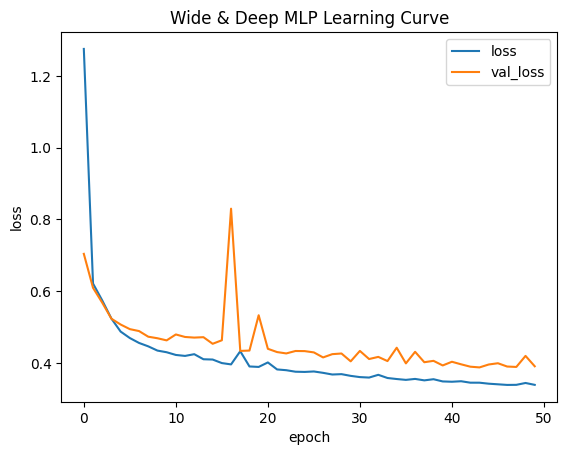

In [66]:
nn_learning_curve(history,"Wide & Deep MLP")

### Test Evaluation

In [68]:
wnd_mse_test = wnd_model.evaluate([X_test_a,X_test_b],y_test)

162/162 [==============================] - 1s 4ms/step - loss: 0.3448


In [69]:
wnd_rmse_test = np.sqrt(wnd_mse_test)
wnd_rmse_test

0.5871796982730595

### Saving the Model

In [70]:
scores = {
    "MSE":wnd_mse_test,
    "RMSE":wnd_rmse_test
}

In [71]:
dump_keras_model(wnd_model,scores=scores)

INFO:tensorflow:Assets written to: Trained Models\2022-08-28_12-29-32_wnd_model\assets


## Conclusion

It doesn't seem like this approach helps any much in improving the prediction accuracy.\
It does improve by a bit but not that much.\
RMSE: 0.5872